In [1]:
import os.path as osp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from scipy import stats
import re

from analysis_utils import read_ann_df, naming_div

IMG_LOCATION=osp.abspath('../generated_items/')

data_dir = osp.abspath('../scenegram_data')
kilogram_dir = osp.abspath('../kilogram')

def clean_raw_ann(s):
    s = re.sub(r'[^a-zA-Z0-9 ]', '', s)
    return s.strip().lower()

sns.set_theme(style="ticks")

In [2]:
input_file = osp.join(data_dir, 'scenegram.csv')
ann_df = read_ann_df(input_file)

tangrams, scenes = zip(*ann_df.index)
tangrams = sorted(set(tangrams))
scenes = sorted(set(scenes))
# 'none' as last scene
scenes.remove('none')
scenes.append('none')

ann_df.raw_annotation = ann_df.raw_annotation.map(clean_raw_ann)

display(ann_df.head())

# make df with kilogram anns

def unpack_anns(list_of_annotations):
    return [x['whole']['wholeAnnotation'] for x in list_of_annotations]

kilogram_path = osp.join(kilogram_dir, 'dataset', 'dense.json')
kilogram_df = pd.read_json(kilogram_path).T
kilogram_df = kilogram_df.loc[tangrams]

kilogram_df['annotation_strings'] = kilogram_df.annotations.map(unpack_anns)

display(kilogram_df.head())

item_identifyer           raw_annotation  \
tangram scene                                                   
page-D  bathroom  3-bathroom-sws2_10    person reading a book   
        bathroom   3-bathroom-sws2_0       bathroom attendant   
        bathroom   3-bathroom-sws2_1                   priest   
        bathroom  3-bathroom-sws2_15                   sliver   
        bathroom   3-bathroom-sws2_6  person holding arms out   

                         clean_annotation           head_noun   wn_lemma  \
tangram scene                                                              
page-D  bathroom    person reading a book              person     person   
        bathroom       bathroom attendant  bathroom attendant  attendant   
        bathroom                   priest              priest     priest   
        bathroom                   sliver              sliver   splinter   
        bathroom  person holding arms out              person     person   

                 selected_synset  \
tangram scene                      
page-D  bathroom     person.n.01   
        bathroom  attendant.n.01   
        bathroom     priest.n.01   
        bathroom   splinter.n.01   
        bathroom     person.n.01   

                                                  synset_definition  \
tangram scene                                                         
page-D  bathroom                                      a human being   
        bathroom  someone who waits on or tends to or attends to...   
        bathroom  a clergyman in Christian churches who has the ...   
        bathroom   a small thin sharp bit or wood or glass or metal   
        bathroom                                      a human being   

                  tangram_id  item_id        image_url partition_name  \
tangram scene                                                           
page-D  bathroom           3       35  035_grid_tr.png           sws2   
        bathroom           3       35  035_grid_tr.png           sws2   
        bathroom           3       35  035_grid_tr.png           sws2   
        bathroom           3       35  035_grid_tr.png           sws2   
        bathroom           3       35  035_grid_tr.png           sws2   

                 workspace_name tangram_pos  order_idx  time_delta  
tangram scene                                                       
page-D  bathroom        sws2_10          tr          9  208.936461  
        bathroom         sws2_0          tr          5  435.840241  
        bathroom         sws2_1          tr          3  130.278864  
        bathroom        sws2_15          tr         27  347.661279  
        bathroom         sws2_6          tr         32  408.685458

,snd,pnd,psa,annotations,annotation_strings
page-D,0.936195,0.662831,4.972391,[{'whole': {'timestamp': '2021-07-29 05:53:45....,"[men, a person standing in prayer, praying man..."
page-H,0.925589,0.751835,4.915825,[{'whole': {'timestamp': '2021-07-29 05:42:37....,"[joker, light lamp, toy, human, man, old man l..."
page1-0,0.954052,0.906744,4.447025,[{'whole': {'timestamp': '2021-07-27 03:05:31....,"[seat, fist, building, a series of mountains, ..."
page1-116,0.873544,0.912755,6.222921,[{'whole': {'timestamp': '2021-07-01 17:47:32....,"[smoking chimney, well, a well, lamp, light, l..."
page1-128,0.978075,0.960254,5.525507,"[{'whole': {'wholeAnnotation': 'an open lock',...","[an open lock, telephone, cleaver, stove, furn..."


In [3]:
# make df with SND values

tuples = list(product(tangrams, scenes))
index = pd.MultiIndex.from_tuples(tuples, names=["tangram", "scene"])

snd_df = pd.DataFrame(index=index, columns=['snd_raw', 'snd_clean', 'snd_head'])

for tangram, scene in snd_df.index:  
    # naming div for cleaned annotations
    scene_raw_annotation_strings = ann_df.loc[tangram, scene].raw_annotation.to_list()
    raw_div = naming_div(scene_raw_annotation_strings)
    snd_df.loc[(tangram, scene), 'snd_raw'] = raw_div
    
    # naming div for cleaned annotations
    snd_clean_annotation_strings = ann_df.loc[tangram, scene].clean_annotation.to_list()
    snd_clean_div = naming_div(snd_clean_annotation_strings)
    snd_df.loc[(tangram, scene), 'snd_clean'] = snd_clean_div
    
    # naming diff for head nouns
    snd_head_annotation_strings = ann_df.loc[tangram, scene].head_noun.to_list()
    snd_head_div = naming_div(snd_head_annotation_strings)
    snd_df.loc[(tangram, scene), 'snd_head'] = snd_head_div

# SND Values per Scene (Table 1)

In [4]:
round_decimals = 2

data = snd_df.reset_index()
scene_snd = pd.DataFrame(index=data.scene.unique())
scene_snd['mean'] = data.groupby('scene').snd_raw.mean().round(round_decimals)
scene_snd['std'] = data.groupby('scene').snd_raw.std().round(round_decimals)
scene_snd['mean/std'] = scene_snd.apply(lambda x: f'{x["mean"].round(round_decimals)}±{x["std"].round(round_decimals)}', axis=1)

print(scene_snd['mean/std'].to_latex())

\begin{tabular}{ll}
\toprule
{} &   mean/std \\
\midrule
bathroom   &  0.92±0.09 \\
beach      &  0.92±0.13 \\
bedroom    &  0.93±0.11 \\
forest     &  0.94±0.06 \\
kitchen    &  0.92±0.11 \\
mountain   &  0.92±0.13 \\
office     &  0.91±0.14 \\
sea\_bottom &  0.95±0.05 \\
sky        &  0.91±0.13 \\
street     &   0.93±0.1 \\
none       &  0.91±0.13 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_22979/2992125402.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(scene_snd['mean/std'].to_latex())


# Plot SND Values per Tangram (Figure 2)

/tmp/ipykernel_22979/2143765963.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  order = data.groupby('tangram').mean()[col].sort_values().index


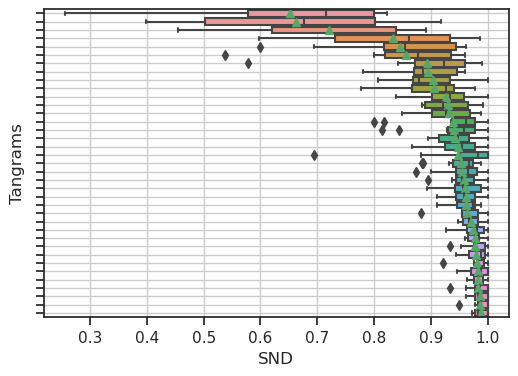

In [5]:
col = 'snd_raw'
data = snd_df.reset_index()

data = pd.merge(
    data, 
    kilogram_df.snd.rename('kilogram_snd'),
    left_on='tangram',
    right_index=True
)

order = data.groupby('tangram').mean()[col].sort_values().index
fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(data, y='tangram', x=col, showmeans=True, order=order)
ax.set(yticklabels=[], ylabel='Tangrams', xlabel='SND')

plt.grid()

# Correlation with kilogram SNDs (Table 1)

In [6]:
series = []

for tangram in tangrams:
    
    # get SND values for the current tangram in each scene
    scene_snds = {
        f'{scene}_snd': snd_df.loc[tangram, scene].snd_raw
        for scene in scenes
    }
    
    # add SND values from kilogram + scene specific SND values to results list
    series.append(pd.Series({
        'tangram': tangram,
        'kilogram_snd': kilogram_df.loc[tangram].snd,
        **scene_snds
    }))
    
combined_with_tg = pd.concat(series, axis=1).T.set_index('tangram').astype(float)

combined_with_tg.head()

,kilogram_snd,bathroom_snd,beach_snd,bedroom_snd,forest_snd,kitchen_snd,mountain_snd,office_snd,sea_bottom_snd,sky_snd,street_snd,none_snd
tangram,,,,,,,,,,,,
page-D,0.936195,0.835185,0.887037,0.959788,0.905556,0.939259,0.885185,0.870926,0.955556,0.953704,0.868519,0.780556
page-H,0.925589,0.853704,0.963889,0.955556,0.891667,0.990741,0.966667,0.578704,0.841667,0.898148,0.954444,0.924074
page1-0,0.954052,0.957407,1.000000,0.959259,0.937037,1.000000,0.944444,0.944444,0.911111,0.977778,0.977778,0.966667
page1-116,0.873544,0.927778,0.951852,0.537654,0.877778,0.906349,0.864815,0.800000,0.960000,0.944444,0.816667,0.822222
page1-128,0.978075,1.000000,0.990000,1.000000,0.977778,0.944444,0.988889,1.000000,0.950000,0.961111,0.988889,0.974074


In [7]:
corr_results = dict()
corr_method = stats.kendalltau

kg_values = combined_with_tg['kilogram_snd'].values

# iterate through scenes
for scene in scenes:
    col = f'{scene}_snd'
    # retrieve SND values for current scene
    scene_values = combined_with_tg[col].values
    # correlate SND values for current scene with kilogram SNDs
    res = corr_method(scene_values, kg_values)
    
    if res.pvalue < 0.001:
        level = '<0.001'
    elif res.pvalue < 0.01:
        level = '<0.01'
    elif res.pvalue < 0.05:
        level = '<0.05'
    else:
        level = '>=0.05'
    
    # add results
    corr_results[scene] = {
        **res._asdict(),
        'significance': res.pvalue < 0.05,
        'level': level
    }

# combine results to DataFrame
corr_df = pd.DataFrame(corr_results).T

def format_corr(row, prec=2): 
    if row.pvalue < 0.001:
        level_marker = '***'
    elif row.pvalue < 0.01:
        level_marker = '**'
    elif row.pvalue < 0.05:
        level_marker = '*'
    else:
        level_marker = ''
    return f'{round(row.correlation, prec)}{level_marker}'

corr_df['corr_formatted'] = corr_df.apply(format_corr, axis=1)

In [8]:
corr_df

,correlation,pvalue,significance,level,corr_formatted
bathroom,0.416444,0.000327,True,<0.001,0.42***
beach,0.460786,0.000085,True,<0.001,0.46***
bedroom,0.37621,0.001236,True,<0.01,0.38**
forest,0.511464,0.000011,True,<0.001,0.51***
kitchen,0.365331,0.001656,True,<0.01,0.37**
mountain,0.412272,0.0004,True,<0.001,0.41***
office,0.509787,0.000013,True,<0.001,0.51***
sea_bottom,0.471151,0.000066,True,<0.001,0.47***
sky,0.334371,0.003946,True,<0.01,0.33**
street,0.507388,0.000014,True,<0.001,0.51***


# Print combined results (Table 1)

In [9]:
combined = pd.concat([scene_snd, corr_df], axis=1)
combined = combined.sort_values(by=f'mean/std')[['mean/std', 'corr_formatted']].rename(columns={'corr_formatted': 'corr.'}).loc[scenes]

print(combined.round(3).to_latex())

\begin{tabular}{lll}
\toprule
{} &   mean/std &    corr. \\
\midrule
bathroom   &  0.92±0.09 &  0.42*** \\
beach      &  0.92±0.13 &  0.46*** \\
bedroom    &  0.93±0.11 &   0.38** \\
forest     &  0.94±0.06 &  0.51*** \\
kitchen    &  0.92±0.11 &   0.37** \\
mountain   &  0.92±0.13 &  0.41*** \\
office     &  0.91±0.14 &  0.51*** \\
sea\_bottom &  0.95±0.05 &  0.47*** \\
sky        &  0.91±0.13 &   0.33** \\
street     &   0.93±0.1 &  0.51*** \\
none       &  0.91±0.13 &  0.61*** \\
\bottomrule
\end{tabular}



/tmp/ipykernel_22979/1941686469.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(combined.round(3).to_latex())
